In [15]:
# imports
from qaoa_application import apply_qaoa_statevector
from qaoa_mincost_k_sat import problem_circuit as puso_problem_circuit, convert_ancilla_bit_results
from qaoa_mincost_sat import problem_circuit as quso_problem_circuit
from configproblem.util.hamiltonian_math import get_hamiltonian_dimension
from configproblem.util.visualization import plot_counts_histogram
from configproblem.util.problem_instance import ProblemInstance
from pprint import pprint
import numpy as np
from qubovert import boolean_var

In [16]:
# define binary vars
x1, x2, x3, x4, x5, x6 = boolean_var('x1'), boolean_var('x2'), boolean_var('x3'), boolean_var('x4'), boolean_var('x5'), boolean_var('x6')

problem_instances = [ProblemInstance([[(x1, True), (x2, True)],
                                      [(x2, True), (x3, False), (x4, True)],
                                      [(x3, True), (x5, False), (x6, False)]],
                                     [x1, x2, x3, x4, x5, x6],
                                     [30, 20, 25, 50, 10, 10])]
alpha_sat = 1000

# qaoa application config
layers = 60 # more layers = higher approximation rate but more quantum errors when running on real qpu
n_features = 6
theta = {"beta": 0.01, "gamma": -0.01} # start values for optimization
strategy = 'min'
use_warmstart = False
use_optimizer = True
print_res = False
warmstart_statevector = None

In [17]:
# print hamiltonians
for index, instance in enumerate(problem_instances):
    print(f"Instance {index}:")
    pprint(instance.get_puso_combined_hamiltonian(alpha_sat))

Hamiltonian 0:
{(): 572.5,
 (0,): 235.0,
 (0, 1): 250.0,
 (1,): 365.0,
 (1, 2): -125.0,
 (1, 2, 3): -125.0,
 (1, 3): 125.0,
 (2,): -12.5,
 (2, 3): -125.0,
 (2, 4): -125.0,
 (2, 4, 5): 125.0,
 (2, 5): -125.0,
 (3,): 100.0,
 (4,): -130.0,
 (4, 5): 125.0,
 (5,): -130.0}


In [18]:
# plot cost landscape

Instance 0:


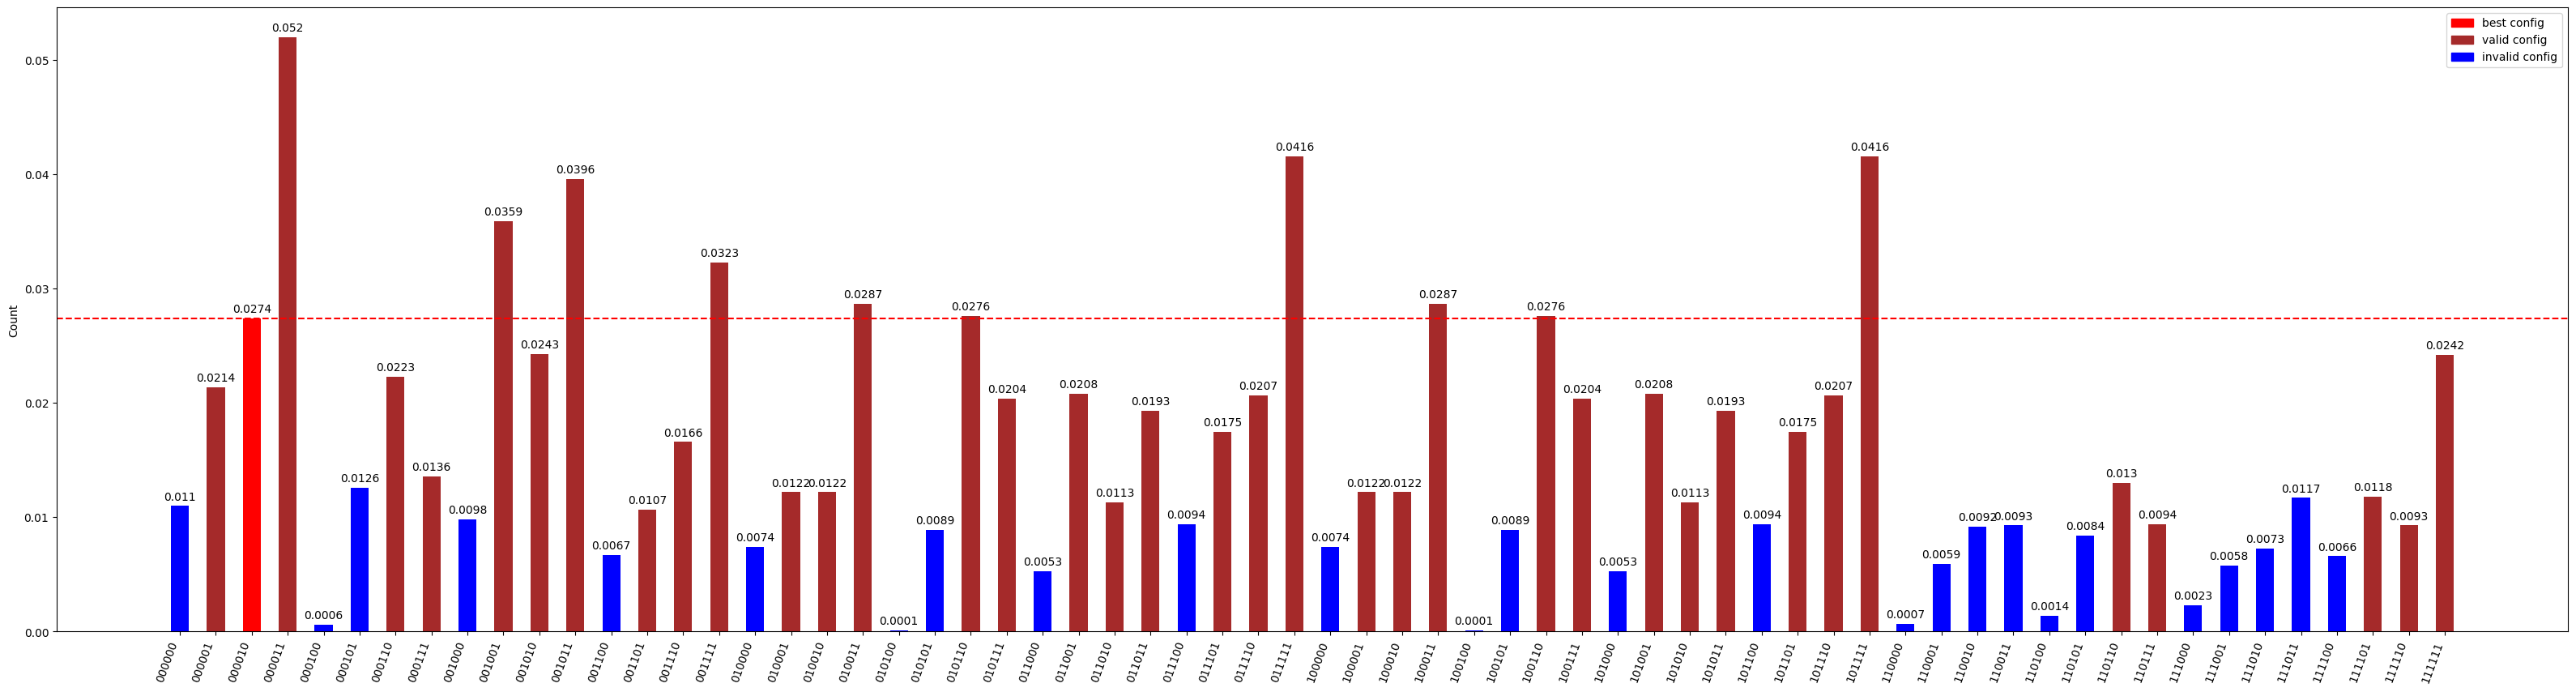

In [19]:
# plot PUBO results
for index, instance in enumerate(problem_instances):
    print(f"Instance {index}:")
    hamiltonian = instance.get_puso_combined_hamiltonian(alpha_sat)

    probabilities, _ = apply_qaoa_statevector(puso_problem_circuit, hamiltonian, layers, get_hamiltonian_dimension(hamiltonian), theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer, print_res=print_res)
    probabilities_dict = {}
    for i in range(0, 2 ** get_hamiltonian_dimension(hamiltonian)):
        probabilities_dict[(np.binary_repr(i, width=get_hamiltonian_dimension(hamiltonian)))] = round(probabilities[i], 4)

    plot_counts_histogram(probabilities_dict, get_hamiltonian_dimension(hamiltonian), instance.get_best_config(), instance.get_valid_configs())

Instance 0:


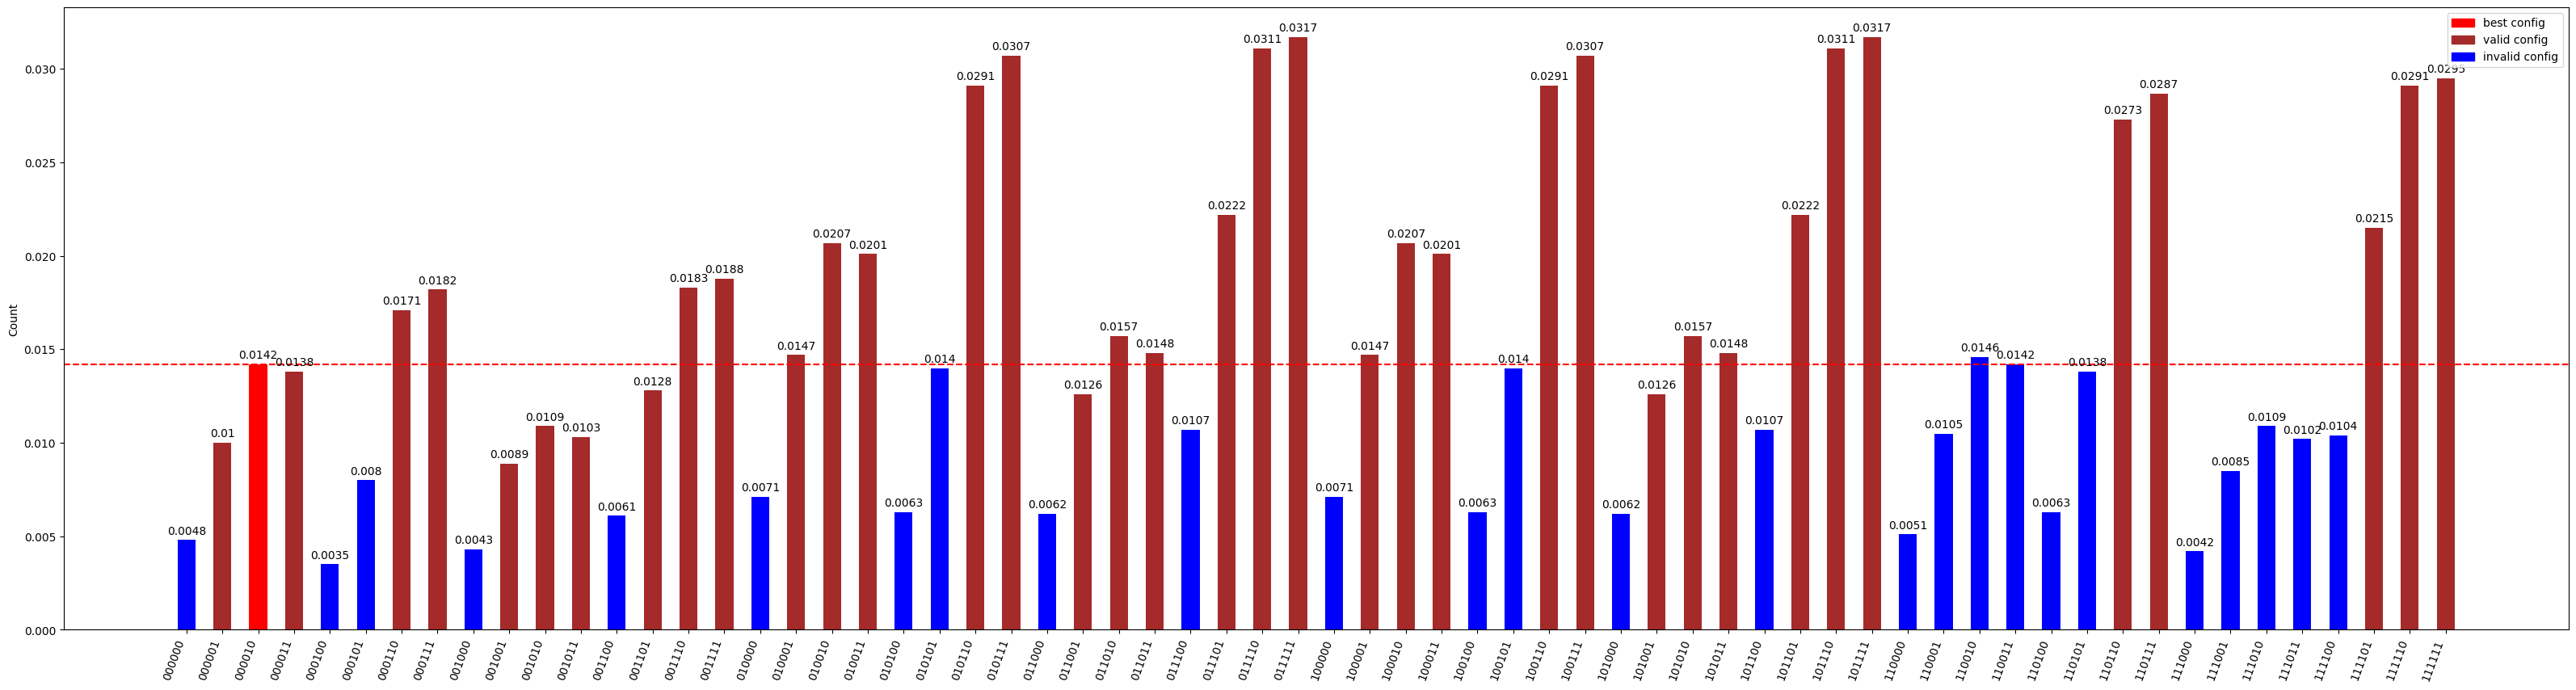

In [20]:
# plot quadratized QUBO results
for index, instance in enumerate(problem_instances):
    print(f"Instance {index}:")
    hamiltonian = instance.get_quso_combined_hamiltonian(alpha_sat)

    probabilities, _ = apply_qaoa_statevector(quso_problem_circuit, hamiltonian, layers, get_hamiltonian_dimension(hamiltonian), theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer, print_res=print_res)
    probabilities_dict = {}
    for i in range(0, 2 ** get_hamiltonian_dimension(hamiltonian)):
        probabilities_dict[np.binary_repr(i, width=get_hamiltonian_dimension(hamiltonian))] = probabilities[i]

    probabilities_dict = convert_ancilla_bit_results(probabilities_dict, n_features)

    for key in probabilities_dict:
        probabilities_dict[key] = round(probabilities_dict[key], 4)

    plot_counts_histogram(probabilities_dict, n_features, instance.get_best_config(), instance.get_valid_configs())